In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_excel('축산유통정보_한우돼지도매가격_일범_230227.xlsx', sheet_name='돼지_도매가격')

In [2]:
def trend(x):
    if re.search('▼', x):
        symbol = -1
    elif re.search('▲', x):
        symbol = 1
    else:
        return np.nan

    x = re.split('▼|▲', x)[1]
    x= re.sub(',|-| ', '', x)

    return float(x) * symbol

df = df.iloc[3:, :2]
df.columns = ['date', 'price']

df['trend'] = df['price'].apply(trend)
df['price'] = df['price'].apply(lambda x: re.split('▼|▲', x)[0] if re.search('▼|▲', x) else x)

df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)
df.dropna(inplace=True)

df['price'] = df['price'].apply(lambda x: re.sub(',|-| ', '', x))
df['price'] = df['price'].astype(float)

df.index = range(len(df))

In [3]:
df

,date,price,trend
0,2015-01-05,4862.0,103.0
1,2015-01-06,4945.0,83.0
2,2015-01-07,4924.0,-21.0
3,2015-01-08,5074.0,150.0
4,2015-01-09,4725.0,-349.0
...,...,...,...
2018,2023-02-20,4785.0,-12.0
2019,2023-02-21,4722.0,-63.0
2020,2023-02-22,4862.0,140.0
2021,2023-02-23,4878.0,16.0


# Train and test

,date,price,trend,price_lead_1
0,2015-01-05,4862.0,103.0,4945.0
1,2015-01-06,4945.0,83.0,4924.0
2,2015-01-07,4924.0,-21.0,5074.0
3,2015-01-08,5074.0,150.0,4725.0
4,2015-01-09,4725.0,-349.0,4802.0
...,...,...,...,...
2017,2023-02-17,4797.0,102.0,4785.0
2018,2023-02-20,4785.0,-12.0,4722.0
2019,2023-02-21,4722.0,-63.0,4862.0
2020,2023-02-22,4862.0,140.0,4878.0


r2:  0.9159400909833133
MAE:  164.37269521945677


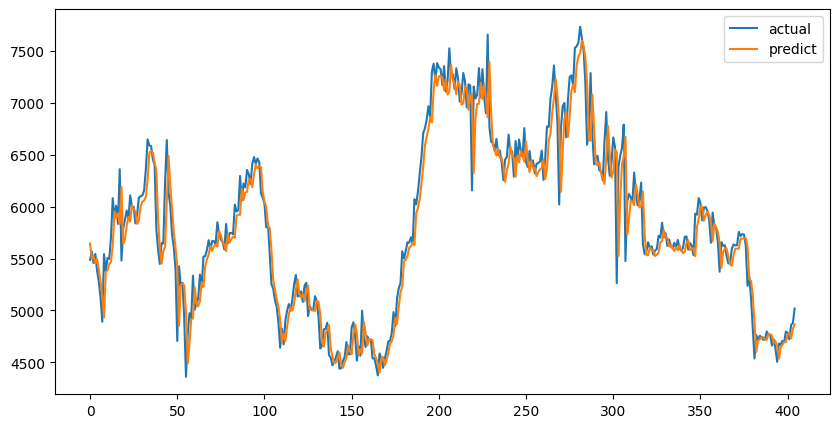

In [4]:
# auto arima
from pmdarima.arima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


data = df.copy()
data['price_lead_1'] = data['price'].shift(-1)
data.dropna(inplace=True)

display(data)

X_train, X_test, y_train, y_test = train_test_split(data[['price', 'trend']], data['price_lead_1'], test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

# predict
pred = model.predict(X_test)

# eval
print('r2: ', r2_score(y_test, pred))
print('MAE: ', mean_absolute_error(y_test, pred))

# visualize
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='actual')
plt.plot(pred, label='predict')
plt.legend()
plt.show()

# Predict

In [42]:
from pmdarima.arima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from datetime import timedelta
from datetime import datetime
import optuna

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Ensemble model

[I 2023-02-28 01:16:08,334] A new study created in memory with name: no-name-0a8db233-f42d-412d-9a71-fc15dc447fc9
[I 2023-02-28 01:16:08,402] Trial 0 finished with value: 1.3354115779938844 and parameters: {'max_depth': 6, 'max_leaf_nodes': 598, 'n_estimators': 458}. Best is trial 0 with value: 1.3354115779938844.
[I 2023-02-28 01:16:08,434] Trial 1 finished with value: 1.5167495896043848 and parameters: {'max_depth': 1, 'max_leaf_nodes': 25, 'n_estimators': 298}. Best is trial 0 with value: 1.3354115779938844.
[I 2023-02-28 01:16:08,473] Trial 2 finished with value: 1.411723865613449 and parameters: {'max_depth': 2, 'max_leaf_nodes': 388, 'n_estimators': 467}. Best is trial 0 with value: 1.3354115779938844.
[I 2023-02-28 01:16:08,537] Trial 3 finished with value: 1.3354115779938844 and parameters: {'max_depth': 6, 'max_leaf_nodes': 872, 'n_estimators': 371}. Best is trial 0 with value: 1.3354115779938844.
[I 2023-02-28 01:16:08,627] Trial 4 finished with value: 1.3812649100491277 and 

<AxesSubplot:xlabel='date'>

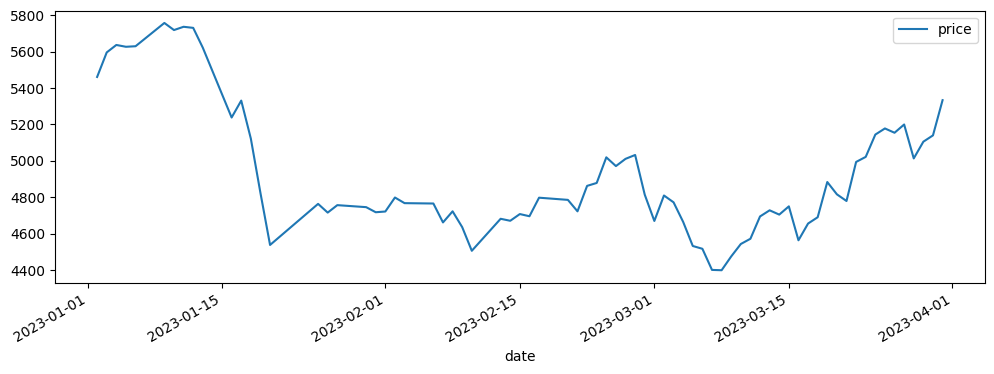

In [71]:
data = df[df['date'] >= '2020-01-01'].copy()
data_cp = df[df['date'] >= '2020-01-01'].copy()

data['price_lead_1'] = data['price'].shift(-1)
data['trend_lead_1'] = data['trend'].shift(-1)

data.dropna(inplace=True)

train_X, train_y = data[['trend']].values, data['trend_lead_1'].values

end_date = datetime.strptime('2023-03-31', '%Y-%m-%d')

def GB_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 20)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 1000)
    n_estimators =  trial.suggest_int('n_estimators', 1, 500)
   
    model = GradientBoostingRegressor(
        max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, 
        # n_estimators = n_estimators, 
        # random_state=25
    )
    model.fit(train_X, train_y)

    train_pred = model.predict(train_X)
    
    return mean_absolute_percentage_error(train_y, train_pred)
    
#Execute optuna and set hyperparameters
GB_study = optuna.create_study(direction='minimize', )
GB_study.optimize(GB_objective, n_trials=50)

# {'max_depth': 10, 'max_leaf_nodes': 33, 'n_estimators': 271}


optimized_GB = GradientBoostingRegressor(
    max_depth = GB_study.best_params['max_depth'], 
    max_leaf_nodes = GB_study.best_params['max_leaf_nodes'],
    n_estimators = GB_study.best_params['n_estimators'],
    # random_state=25
)
# optimized_GB = GradientBoostingRegressor(
#     max_depth = 10, 
#     max_leaf_nodes = 33,
#     n_estimators = 271,
#     random_state=25
# )
optimized_GB.fit(train_X, train_y)

while data_cp.iloc[-1].date < end_date:
    last_row = data_cp.iloc[-1]

    # new_prediction = model.predict(data_cp[['trend']].iloc[[-1]].values).item()
    new_trend = optimized_GB.predict(data_cp[['trend']].iloc[[-1]].values).item()
    
    new_date  = last_row.date + timedelta(days=1)
    new_row = [
        new_date,
        last_row.price + new_trend,
        new_trend,
    ]

    # concate new row to data_cp, and keep index in order
    data_cp = pd.concat([data_cp, pd.DataFrame([new_row], columns=['date', 'price', 'trend'])], ignore_index=True)

data_cp[data_cp['date'] >= '2023-01-01'].plot(x='date', y='price', figsize=(12, 4))

<AxesSubplot:xlabel='date'>

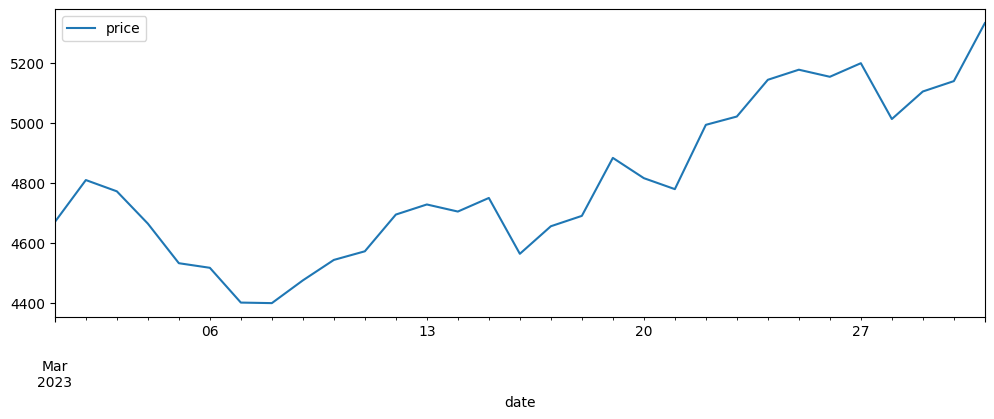

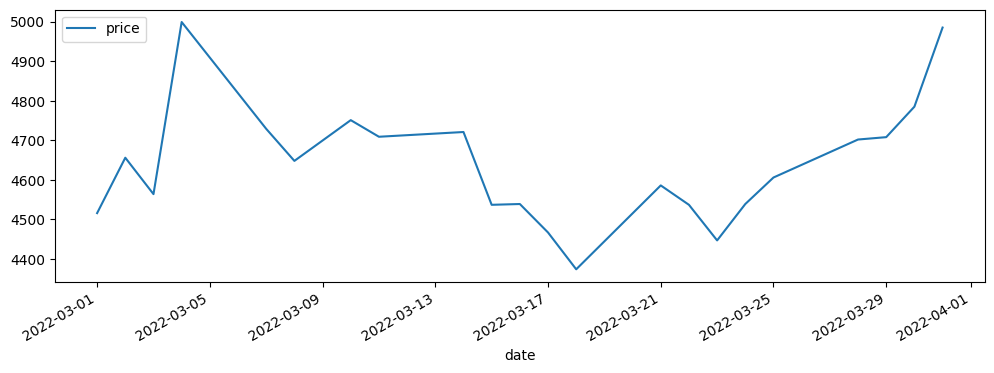

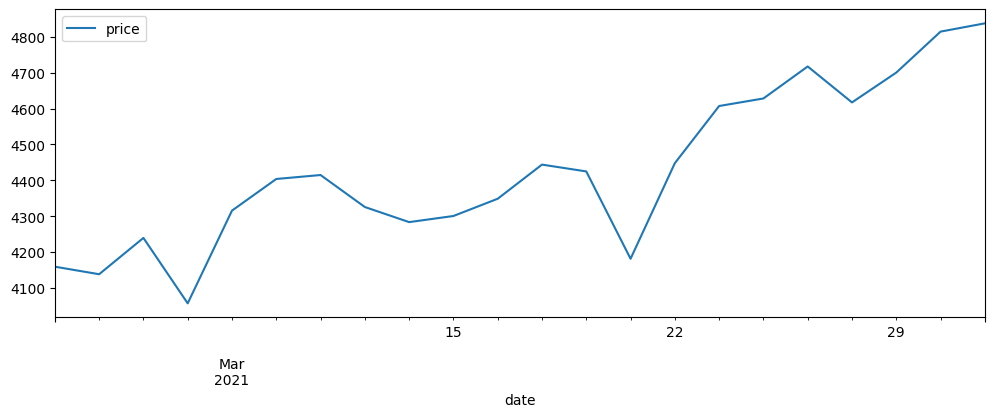

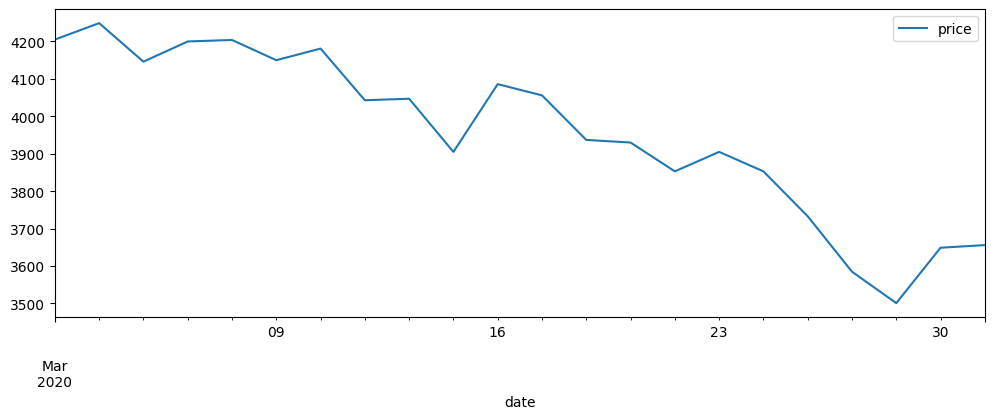

In [77]:
data_cp[(data_cp['date'] >= '2023-03-01') & (data_cp['date'] <= '2023-03-31')].plot(x='date', y='price', figsize=(12, 4))

data_cp[(data_cp['date'] >= '2022-03-01') & (data_cp['date'] <= '2022-03-31')].plot(x='date', y='price', figsize=(12, 4))

data_cp[(data_cp['date'] >= '2021-03-01') & (data_cp['date'] <= '2021-03-31')].plot(x='date', y='price', figsize=(12, 4))

data_cp[(data_cp['date'] >= '2020-03-01') & (data_cp['date'] <= '2020-03-31')].plot(x='date', y='price', figsize=(12, 4))

In [78]:
data_cp[data_cp['date'] >= '2023-03-01'].to_clipboard(index=False)

# ARIMA

In [40]:
from statsmodels.tsa.arima.model import ARIMA

data = df.copy() # [df['date'] > '2018-01-01']
data_cp = df.copy() # [df['date'] > '2018-01-01']

end_date = datetime.strptime('2023-03-31', '%Y-%m-%d')

while data_cp.iloc[-1].date < end_date:
    y = data_cp['price'].values
    last_row = data_cp.iloc[-1]

    SARIMA_model = auto_arima(y, error_action='ignore', suppress_warnings=True, stepwise=False, seasonal=False)
    model = ARIMA(y, order=SARIMA_model.order).fit()

    new_prediction = model.forecast(1).item()
    
    new_date  = last_row.date + timedelta(days=1)
    new_row = [
        new_date,
        new_prediction,
        last_row.price - new_prediction,
    ]

    # concate new row to data_cp, and keep index in order
    data_cp = pd.concat([data_cp, pd.DataFrame([new_row], columns=['date', 'price', 'trend'])], ignore_index=True)

In [ ]:
data_cp[data_cp['date'] >= '2023-01-01'].plot(x='date', y='price', figsize=(20, 15))

# neural network